**Wine Quality – Spark ML & Pipelines**

In this notebook we:
- merge the red and white wine datasets into a single DataFrame,
- do some basic exploration (schema, summary stats) and a correlation matrix to get a first idea
  of how the chemical features relate to each other and to quality,
- build a regression pipeline with RandomForestRegressor to:
  - predict the numeric quality score from the chemical properties,
  - check how well this works using RMSE and R²,
  - see which features are the most important for the regression task,
- build a classification pipeline to predict whether a wine is “good” (for example, quality >= 7),
  where we train:
  - a shallow Decision Tree to get simple, human-readable decision rules,
  - a deeper Decision Tree to see what happens when we allow more complexity,
  - a Random Forest classifier to try to improve performance and stability over a single tree,
  - a Logistic Regression model as a simple linear baseline,
  - a simple deep learning model with 3 layers
- compare all classification models using accuracy, F1-score and a confusion matrix,
- and finally, summarise:
  - how well wine quality can be predicted from these chemical features,
  - which variables seem to matter the most,
  - and which classification model is the most useful for the “good vs. not good” decision.

In [57]:
#1 imports

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, count, isnan

from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.classification import (
    DecisionTreeClassifier,
    RandomForestClassifier,
    LogisticRegression
)
from pyspark.ml.evaluation import RegressionEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.stat import Correlation

from pyspark.ml.linalg import DenseMatrix

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-17-openjdk-amd64"
os.environ["PATH"] = os.environ["JAVA_HOME"] + "/bin:" + os.environ["PATH"]

spark = SparkSession.builder \
    .appName("WineQualityAnalysis") \
    .master("local[*]") \
    .config("spark.driver.memory", "4g") \
    .getOrCreate()

spark


In [58]:
#2 loading data
red_path = "DATA/winequality-red.csv"
white_path = "DATA/winequality-white.csv"

red = spark.read.csv(red_path, header=True, inferSchema=True, sep=";") \
    .withColumn("type", when(col("quality").isNotNull(), "red"))

white = spark.read.csv(white_path, header=True, inferSchema=True, sep=";") \
    .withColumn("type", when(col("quality").isNotNull(), "white"))

wine = red.unionByName(white)

print("Number of rows:", wine.count())
wine.show(10)



Number of rows: 6497
+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+-------+----+
|fixed acidity|volatile acidity|citric acid|residual sugar|chlorides|free sulfur dioxide|total sulfur dioxide|density|  pH|sulphates|alcohol|quality|type|
+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+-------+----+
|          7.4|             0.7|        0.0|           1.9|    0.076|               11.0|                34.0| 0.9978|3.51|     0.56|    9.4|      5| red|
|          7.8|            0.88|        0.0|           2.6|    0.098|               25.0|                67.0| 0.9968| 3.2|     0.68|    9.8|      5| red|
|          7.8|            0.76|       0.04|           2.3|    0.092|               15.0|                54.0|  0.997|3.26|     0.65|    9.8|      5| red|
|         11.2|            0.28|       0.56|     

In [59]:
#3 basic exploration -> O missig values

wine.printSchema()

from pyspark.sql.functions import col, when, count, isnan, lit

num_types = {"int", "bigint", "double", "float"}

missing = wine.select([
    count(
        when(
            # always check for NULL
            (col(c).isNull()) |
            # for numeric columns also check isnan(...)
            (isnan(col(c)) if t in num_types else lit(False)),
            c
        )
    ).alias(c)
    for c, t in wine.dtypes
])

print("Number of missing values per column:")
missing.show()


root
 |-- fixed acidity: double (nullable = true)
 |-- volatile acidity: double (nullable = true)
 |-- citric acid: double (nullable = true)
 |-- residual sugar: double (nullable = true)
 |-- chlorides: double (nullable = true)
 |-- free sulfur dioxide: double (nullable = true)
 |-- total sulfur dioxide: double (nullable = true)
 |-- density: double (nullable = true)
 |-- pH: double (nullable = true)
 |-- sulphates: double (nullable = true)
 |-- alcohol: double (nullable = true)
 |-- quality: integer (nullable = true)
 |-- type: string (nullable = true)

Number of missing values per column:
+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+---+---------+-------+-------+----+
|fixed acidity|volatile acidity|citric acid|residual sugar|chlorides|free sulfur dioxide|total sulfur dioxide|density| pH|sulphates|alcohol|quality|type|
+-------------+----------------+-----------+--------------+---------+-------------------+-----

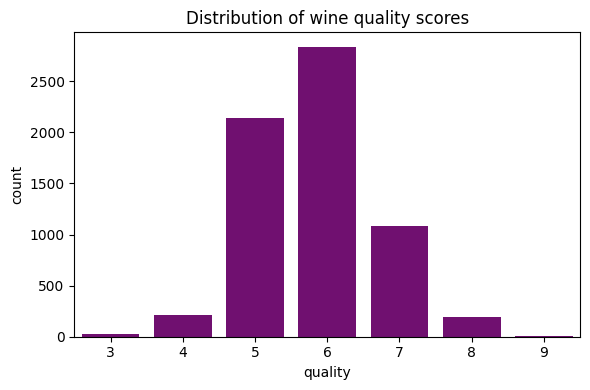

In [60]:
#4 PLOTS!

quality_pd = wine.select("quality").toPandas()

plt.figure(figsize=(6, 4))
sns.countplot(data=quality_pd, x="quality", color="purple")
plt.title("Distribution of wine quality scores")
plt.xlabel("quality")
plt.ylabel("count")
plt.tight_layout()
plt.show()



In [61]:
from pyspark.sql.functions import col

# we assume that 1 = good wine (quality >= 7), 0 = otherwise
wine_clf = wine.withColumn(
    "label",
    (col("quality") >= 7).cast("int")
)

wine_clf.select("quality", "label").show(10)




+-------+-----+
|quality|label|
+-------+-----+
|      5|    0|
|      5|    0|
|      5|    0|
|      6|    0|
|      5|    0|
|      5|    0|
|      5|    0|
|      7|    1|
|      7|    1|
|      5|    0|
+-------+-----+
only showing top 10 rows


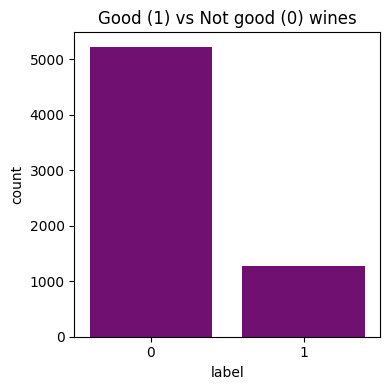

In [62]:
# distribution of the binary quality (0 = not good, 1 = good)

wine_pd = wine_clf.select("label").toPandas()

plt.figure(figsize=(4, 4))
sns.countplot(data=wine_pd, x="label", color="purple")
plt.title("Good (1) vs Not good (0) wines")
plt.xlabel("label")
plt.ylabel("count")
plt.tight_layout()
plt.show()



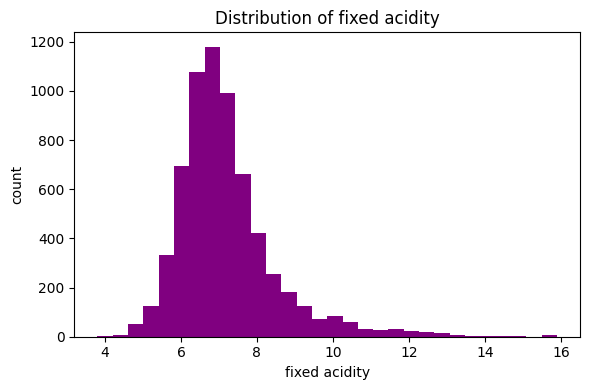

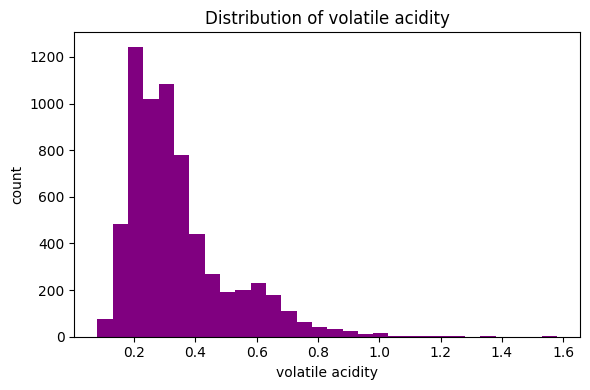

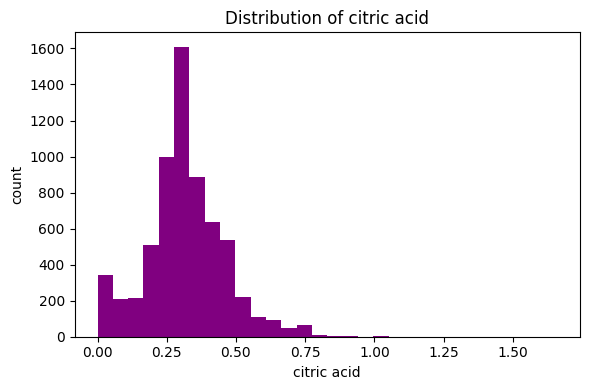

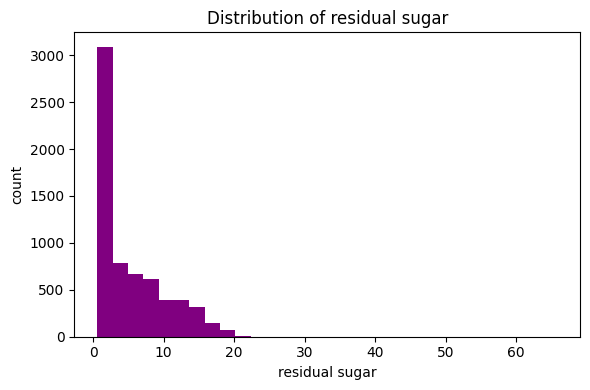

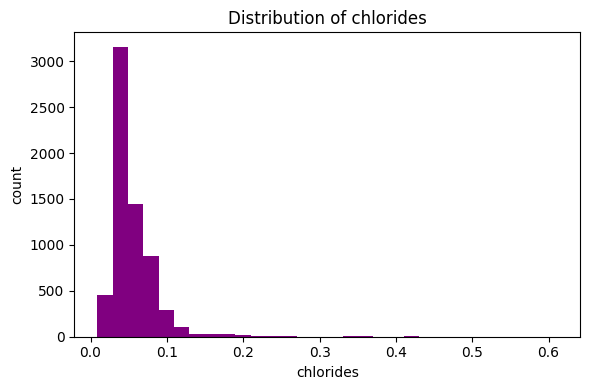

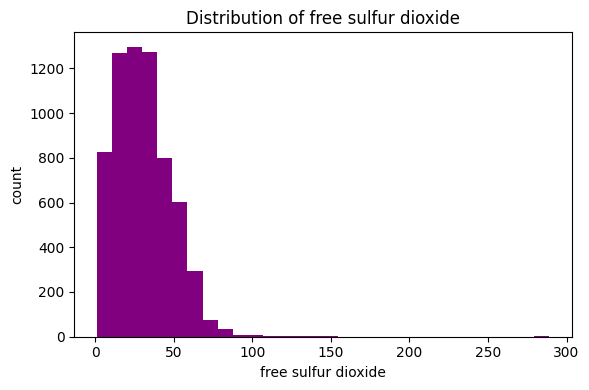

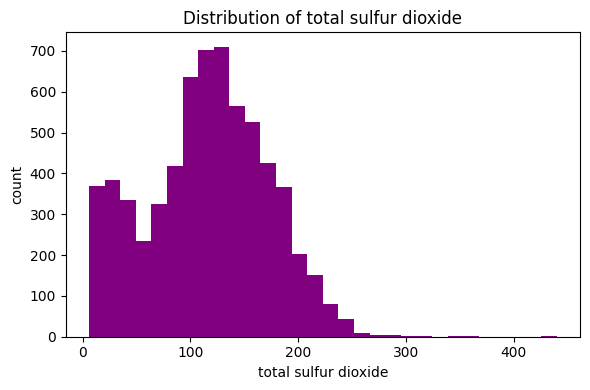

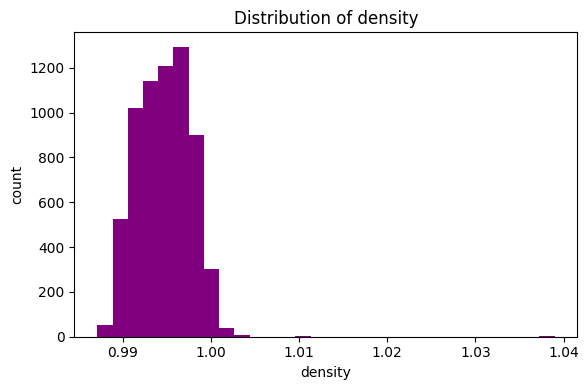

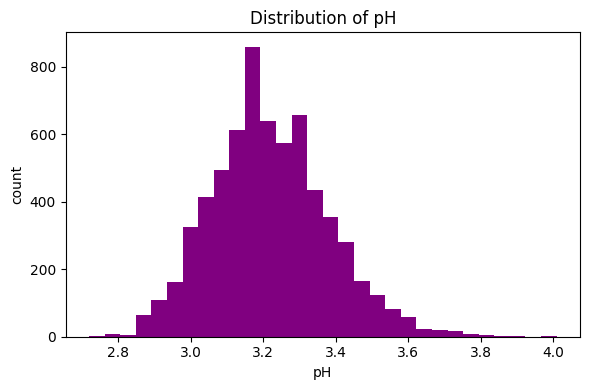

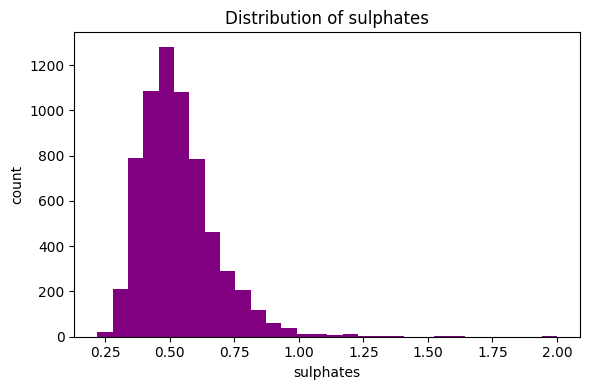

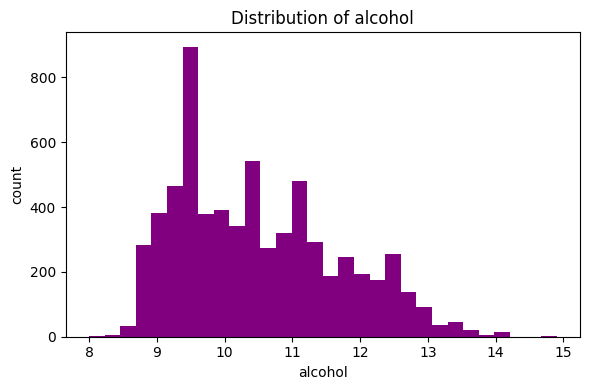

In [63]:
# Histograms plots for all numeric columns

numeric_cols = [
    "fixed acidity",
    "volatile acidity",
    "citric acid",
    "residual sugar",
    "chlorides",
    "free sulfur dioxide",
    "total sulfur dioxide",
    "density",
    "pH",
    "sulphates",
    "alcohol"
]

wine_pd_all = wine.select(numeric_cols + ["type"]).toPandas()

for col_name in numeric_cols:
    plt.figure(figsize=(6, 4))
    plt.hist(wine_pd_all[col_name], bins=30,color="purple")
    plt.title(f"Distribution of {col_name}")
    plt.xlabel(col_name)
    plt.ylabel("count")
    plt.tight_layout()
    plt.show()


In [64]:
#5 corealtion matrix and Vectorassembler
numeric_cols = [c for c, t in wine.dtypes if t in ("int", "double") and c != "quality"]

print("Columns used for correlation:", numeric_cols)

assembler_corr = VectorAssembler(
    inputCols=numeric_cols,
    outputCol="features_corr"
)

wine_vec = assembler_corr.transform(wine).select("features_corr")
corr_matrix = Correlation.corr(wine_vec, "features_corr", "pearson").head()[0]

pd.DataFrame(corr_matrix.toArray(), columns=numeric_cols, index=numeric_cols)


Columns used for correlation: ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
fixed acidity,1.000000,0.219008,0.324436,-0.111981,0.298195,-0.282735,-0.329054,0.458910,-0.252700,0.299568,-0.095452
volatile acidity,0.219008,1.000000,-0.377981,-0.196011,0.377124,-0.352557,-0.414476,0.271296,0.261454,0.225984,-0.037640
citric acid,0.324436,-0.377981,1.000000,0.142451,0.038998,0.133126,0.195242,0.096154,-0.329808,0.056197,-0.010493
residual sugar,-0.111981,-0.196011,0.142451,1.000000,-0.128940,0.402871,0.495482,0.552517,-0.267320,-0.185927,-0.359415
chlorides,0.298195,0.377124,0.038998,-0.128940,1.000000,-0.195045,-0.279630,0.362615,0.044708,0.395593,-0.256916
free sulfur dioxide,-0.282735,-0.352557,0.133126,0.402871,-0.195045,1.000000,0.720934,0.025717,-0.145854,-0.188457,-0.179838
total sulfur dioxide,-0.329054,-0.414476,0.195242,0.495482,-0.279630,0.720934,1.000000,0.032395,-0.238413,-0.275727,-0.265740
density,0.458910,0.271296,0.096154,0.552517,0.362615,0.025717,0.032395,1.000000,0.011686,0.259478,-0.686745
pH,-0.252700,0.261454,-0.329808,-0.267320,0.044708,-0.145854,-0.238413,0.011686,1.000000,0.192123,0.121248
sulphates,0.299568,0.225984,0.056197,-0.185927,0.395593,-0.188457,-0.275727,0.259478,0.192123,1.000000,-0.003029


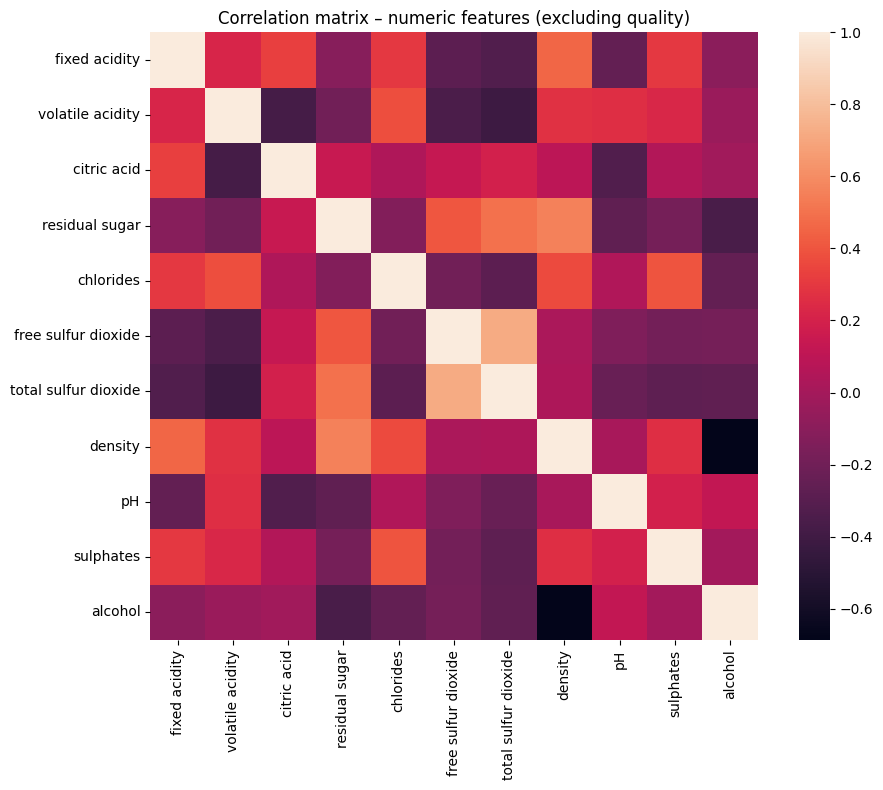

In [65]:
#6 visualisation - heatmap
corr_array = np.array(corr_matrix.toArray())
corr_df = pd.DataFrame(corr_array, index=numeric_cols, columns=numeric_cols)

plt.figure(figsize=(10, 8))
sns.heatmap(corr_df, annot=False, square=True)
plt.title("Correlation matrix – numeric features (excluding quality)")
plt.tight_layout()
plt.show()


1.Free and Total Sulfur Dioxide provide duplicate information, so we are deciding to remove one feature to avoid model instability.

2.Density is heavily dependent on Alcohol and Sugar levels, so we are deciding to drop it as it creates noise without adding new signal.

3.The link between Fixed Acidity and pH is unexpectedly weak due to buffering agents, so we are deciding to keep both features to preserve unique chemical details.

In [66]:
#7 regression pipeline (RandomForestRegressor), 100 trees, max deep =10 and 80/20, basing on the chemical features we are  forecasting quality of the wine
#We are escluding Free Sulfur Dioxide and Density
indexer = StringIndexer(inputCol="type", outputCol="type_indexed")

feature_cols_reg = [c for c in wine.columns if c not in ("quality", "type", "density", "free sulfur dioxide")]
assembler_reg = VectorAssembler(
    inputCols=feature_cols_reg,
    outputCol="features_assembled_reg"
)

scaler_reg = StandardScaler(
    inputCol="features_assembled_reg",
    outputCol="features_reg",
    withStd=True,
    withMean=False
)

rf_reg = RandomForestRegressor(
    labelCol="quality",
    featuresCol="features_reg",
    numTrees=100,
    maxDepth=10,
    seed=42
)

pipeline_reg = Pipeline(stages=[indexer, assembler_reg, scaler_reg, rf_reg])

train_reg, test_reg = wine.randomSplit([0.8, 0.2], seed=42)

model_reg = pipeline_reg.fit(train_reg)
pred_reg = model_reg.transform(test_reg)

pred_reg.select("quality", "prediction").show(10)


25/12/12 17:36:07 WARN DAGScheduler: Broadcasting large task binary with size 1020.5 KiB
25/12/12 17:36:08 WARN DAGScheduler: Broadcasting large task binary with size 1823.5 KiB
25/12/12 17:36:08 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB
25/12/12 17:36:09 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB
25/12/12 17:36:10 WARN DAGScheduler: Broadcasting large task binary with size 7.5 MiB
25/12/12 17:36:10 WARN DAGScheduler: Broadcasting large task binary with size 1204.2 KiB


+-------+------------------+
|quality|        prediction|
+-------+------------------+
|      7| 6.691416949374781|
|      6| 5.849319927170518|
|      5| 5.668763986396305|
|      5| 5.134250086601976|
|      7|6.9073348075582075|
|      7| 6.238248023839873|
|      5| 5.306875826025658|
|      5|5.6334314409537125|
|      6| 6.335571532973046|
|      6| 5.501275595538405|
+-------+------------------+
only showing top 10 rows


In [67]:
#8 evaluation of regression
evaluator_rmse = RegressionEvaluator(
    labelCol="quality",
    predictionCol="prediction",
    metricName="rmse"
)

evaluator_r2 = RegressionEvaluator(
    labelCol="quality",
    predictionCol="prediction",
    metricName="r2"
)

rmse = evaluator_rmse.evaluate(pred_reg)
r2 = evaluator_r2.evaluate(pred_reg)

print(f"RandomForestRegressor – RMSE: {rmse:.3f}")
print(f"RandomForestRegressor – R²:   {r2:.3f}")


RandomForestRegressor – RMSE: 0.657
RandomForestRegressor – R²:   0.430


RMSE: 0.647
The root mean squared error is 0.657. This is the average distance between the predicted and true quality scores. The lower this value, the better. Since wine quality scores are usually between 3 and 9, an RMSE of about 0.65 means the model is reasonably accurate, but of course not perfect.

R²: 0.447
The R² value of 0.430 means that the model explains about 43% of the variation in wine quality based on the chemical features. This is a moderate value. It suggests that chemistry does matter, but there are also other important factors not included in the dataset (e.g. region, vintage, tasting conditions, individual expert preferences), or that the model cannot fully capture all the complexity of the problem.

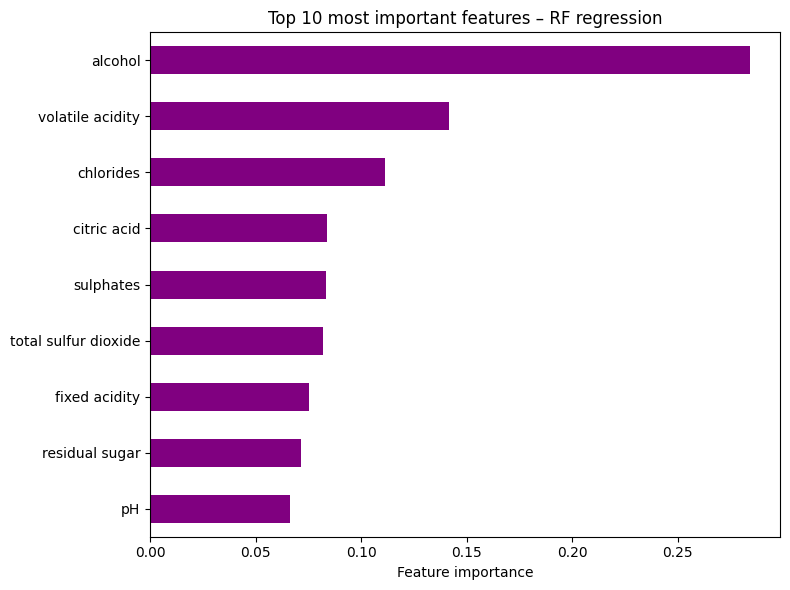

alcohol                 0.284334
volatile acidity        0.141677
chlorides               0.111128
citric acid             0.083835
sulphates               0.083229
total sulfur dioxide    0.082121
fixed acidity           0.075546
residual sugar          0.071748
pH                      0.066384
dtype: float64

In [68]:
#9 feature importance for regression
rf_reg_model = model_reg.stages[-1]

importances = rf_reg_model.featureImportances

feature_importances = pd.Series(
    importances.toArray(),
    index=feature_cols_reg
).sort_values(ascending=False)

plt.figure(figsize=(8, 6))
feature_importances.head(10).plot(kind="barh", color="purple")
plt.gca().invert_yaxis()
plt.title("Top 10 most important features – RF regression")
plt.xlabel("Feature importance")
plt.tight_layout()
plt.show()

feature_importances.head(10)



alcohol (0.2848) –  the most important feature. Higher alcohol content is strongly associated with higher predicted wine quality. This is consistent with intuition and the earlier correlation analysis.

volatile acidity (0.1416) - second most important feature. Lower volatile acidity is typically linked to better-quality wines.

chlorides (0.1111) – also important feature

In [69]:
#10 preparing data for classification ->clasyfiing wine into 2 categories 1 good 0 not good
from pyspark.sql.functions import col

#good wine is over 7 thats why we are creating label: 1 = good wine (quality >= 7), 0 = otherwise
wine_clf = wine.withColumn(
    "label",
    (col("quality") >= 7).cast("int")
)

wine_clf.select("quality", "label").show(10)

train_clf, test_clf = wine_clf.randomSplit([0.8, 0.2], seed=42)
print("Train:", train_clf.count(), "Test:", test_clf.count())


+-------+-----+
|quality|label|
+-------+-----+
|      5|    0|
|      5|    0|
|      5|    0|
|      6|    0|
|      5|    0|
|      5|    0|
|      5|    0|
|      7|    1|
|      7|    1|
|      5|    0|
+-------+-----+
only showing top 10 rows
Train: 5262 Test: 1235


In [70]:
#11 excluding quality,  label and 'type'
feature_cols_numeric_clf = [c for c in wine_clf.columns if c not in ("quality", "type", "label", "density", "free sulfur dioxide")]

indexer_clf = StringIndexer(inputCol="type", outputCol="type_indexed")


assembler_clf = VectorAssembler(
    inputCols=feature_cols_numeric_clf + [indexer_clf.getOutputCol()],
    outputCol="features_assembled_clf"
)

scaler_clf = StandardScaler(
    inputCol="features_assembled_clf",
    outputCol="features_clf",
    withStd=True,
    withMean=False
)

feature_cols_clf = feature_cols_numeric_clf + [indexer_clf.getOutputCol()]

In [71]:
#12 buliding 2 trees,  forest add logistic regression

# shallow decision tree - (less risk  of overfitting, more easy to interpret)
dt_shallow = DecisionTreeClassifier(
    labelCol="label",
    featuresCol="features_clf",
    maxDepth=3,
    seed=42
)

# deep decision tree (can overfit more easily!)
dt_deep = DecisionTreeClassifier(
    labelCol="label",
    featuresCol="features_clf",
    maxDepth=12,
    seed=42
)

# RF
rf_clf = RandomForestClassifier(
    labelCol="label",
    featuresCol="features_clf",
    numTrees=100,
    maxDepth=10,
    seed=42
)

# Logistic regression
log_reg = LogisticRegression(
    labelCol="label",
    featuresCol="features_clf",
    maxIter=50,
    regParam=0.1,
    elasticNetParam=0.0
)

pipeline_dt_shallow = Pipeline(stages=[indexer_clf, assembler_clf, scaler_clf, dt_shallow])
pipeline_dt_deep    = Pipeline(stages=[indexer_clf, assembler_clf, scaler_clf, dt_deep])
pipeline_rf_clf     = Pipeline(stages=[indexer_clf, assembler_clf, scaler_clf, rf_clf])
pipeline_log_reg    = Pipeline(stages=[indexer_clf, assembler_clf, scaler_clf, log_reg])

In [72]:
#13 traning and comparing models
evaluator_acc = MulticlassClassificationEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="accuracy"
)

evaluator_f1 = MulticlassClassificationEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="f1"
)

models = {
    "DecisionTree_shallow (maxDepth=3)": pipeline_dt_shallow,
    "DecisionTree_deep (maxDepth=12)": pipeline_dt_deep,
    "RandomForest (100 trees)": pipeline_rf_clf,
    "LogisticRegression": pipeline_log_reg
}

results = []

for name, pipeline in models.items():
    print(f"\n=== Model: {name} ===")
    model = pipeline.fit(train_clf)
    pred = model.transform(test_clf)

    acc = evaluator_acc.evaluate(pred)
    f1  = evaluator_f1.evaluate(pred)

    print(f"Accuracy: {acc:.3f}")
    print(f"F1-score: {f1:.3f}")

    results.append((name, acc, f1))

results_df = pd.DataFrame(results, columns=["Model", "Accuracy", "F1"])
results_df



=== Model: DecisionTree_shallow (maxDepth=3) ===
Accuracy: 0.798
F1-score: 0.779

=== Model: DecisionTree_deep (maxDepth=12) ===
Accuracy: 0.818
F1-score: 0.822

=== Model: RandomForest (100 trees) ===


25/12/12 17:36:17 WARN DAGScheduler: Broadcasting large task binary with size 1595.5 KiB
25/12/12 17:36:17 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
25/12/12 17:36:18 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
25/12/12 17:36:19 WARN DAGScheduler: Broadcasting large task binary with size 5.2 MiB
25/12/12 17:36:20 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
25/12/12 17:36:21 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB


Accuracy: 0.861
F1-score: 0.845

=== Model: LogisticRegression ===
Accuracy: 0.803
F1-score: 0.720


,Model,Accuracy,F1
0,DecisionTree_shallow (maxDepth=3),0.798381,0.778751
1,DecisionTree_deep (maxDepth=12),0.817814,0.821550
2,RandomForest (100 trees),0.860729,0.845442
3,LogisticRegression,0.803239,0.720158


RandomForest (100 trees) performs best – highest Accuracy (0.86) and F1 (0.84).

Deep decision tree is second – decent improvement over the shallow tree.

Shallow Decision Tree and Logistic Regression have similar Accuracy (0.80), but Logistic Regression has lower F1, so it handles the good class worse

In [73]:
#14 Retrain the best model on the full training data ->RF
best_model = pipeline_rf_clf.fit(train_clf)
pred_best = best_model.transform(test_clf)

pred_best.select("label", "prediction").show(10)


25/12/12 17:36:24 WARN DAGScheduler: Broadcasting large task binary with size 1595.5 KiB
25/12/12 17:36:24 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
25/12/12 17:36:25 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
25/12/12 17:36:26 WARN DAGScheduler: Broadcasting large task binary with size 5.2 MiB


+-----+----------+
|label|prediction|
+-----+----------+
|    1|       1.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    1|       1.0|
|    1|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
+-----+----------+
only showing top 10 rows


25/12/12 17:36:27 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB


25/12/12 17:36:28 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB


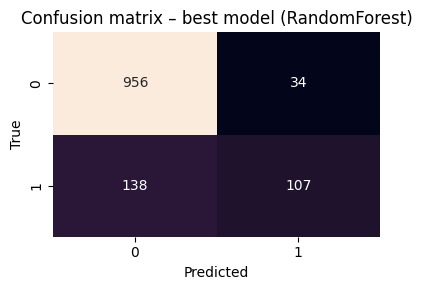

Confusion matrix (RF):
[[956  34]
 [138 107]]


In [74]:
#15 generating confusion matrix to evaluate the RF
from sklearn.metrics import confusion_matrix

y_true = np.array(pred_best.select("label").toPandas()["label"])
y_pred = np.array(pred_best.select("prediction").toPandas()["prediction"])

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt="d", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion matrix – best model (RandomForest)")
plt.tight_layout()
plt.show()

print("Confusion matrix (RF):")
print(cm)



The confusion matrix suggests that the Random Forest model handles the “not good” wines much better than the “good” ones. It rarely marks a bad wine as good, but quite often fails to recognise good wines and classifies them as not good. In other words, the model is quite conservative – it prefers to be strict when giving the “good” label, which leads to lower recall for that class.

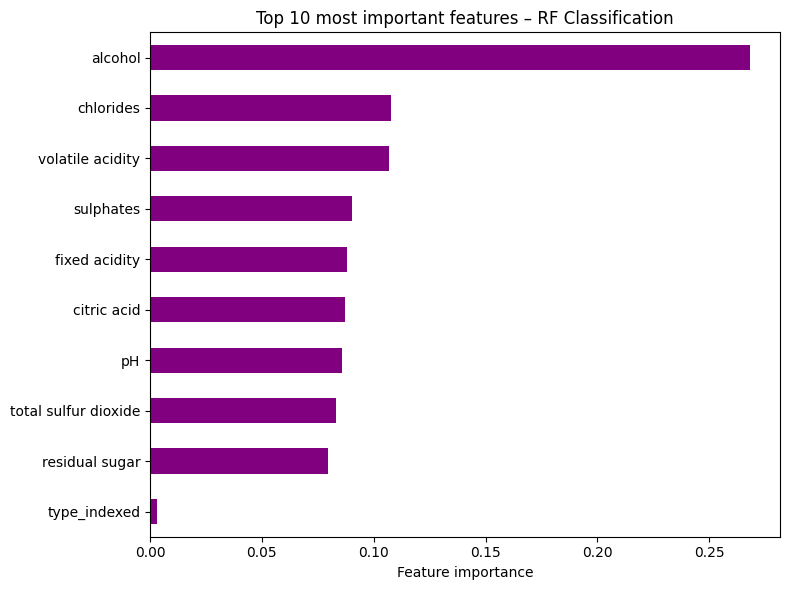

In [75]:
#16 Getting insights form Random Forest
import pandas as pd
import matplotlib.pyplot as plt

rf_clf_model = best_model.stages[-1]

importances = rf_clf_model.featureImportances
feature_cols = assembler_clf.getInputCols()

feature_importances_clf = pd.Series(
    importances.toArray(),
    index=feature_cols
).sort_values(ascending=False)

plt.figure(figsize=(8, 6))
feature_importances_clf.head(10).plot(kind="barh", color="purple")
plt.gca().invert_yaxis()  
plt.title("Top 10 most important features – RF Classification")
plt.xlabel("Feature importance")
plt.tight_layout()
plt.show()



In [76]:
#17 insights form decision tree - as in comparison to RF they are easier to interpret
numeric_features_for_tree = [
    "fixed acidity",
    "volatile acidity",
    "citric acid",
    "residual sugar",
    "chlorides",
    "total sulfur dioxide",
    "pH",
    "sulphates",
    "alcohol"
]

cols_for_sklearn = numeric_features_for_tree + ["label"]

wine_sklearn_pd = wine_clf.select(cols_for_sklearn).toPandas()

X = wine_sklearn_pd[numeric_features_for_tree]
y = wine_sklearn_pd["label"]

X.head(), y.head()



(   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
 0            7.4              0.70         0.00             1.9      0.076   
 1            7.8              0.88         0.00             2.6      0.098   
 2            7.8              0.76         0.04             2.3      0.092   
 3           11.2              0.28         0.56             1.9      0.075   
 4            7.4              0.70         0.00             1.9      0.076   
 
    total sulfur dioxide    pH  sulphates  alcohol  
 0                  34.0  3.51       0.56      9.4  
 1                  67.0  3.20       0.68      9.8  
 2                  54.0  3.26       0.65      9.8  
 3                  60.0  3.16       0.58      9.8  
 4                  34.0  3.51       0.56      9.4  ,
 0    0
 1    0
 2    0
 3    0
 4    0
 Name: label, dtype: int32)

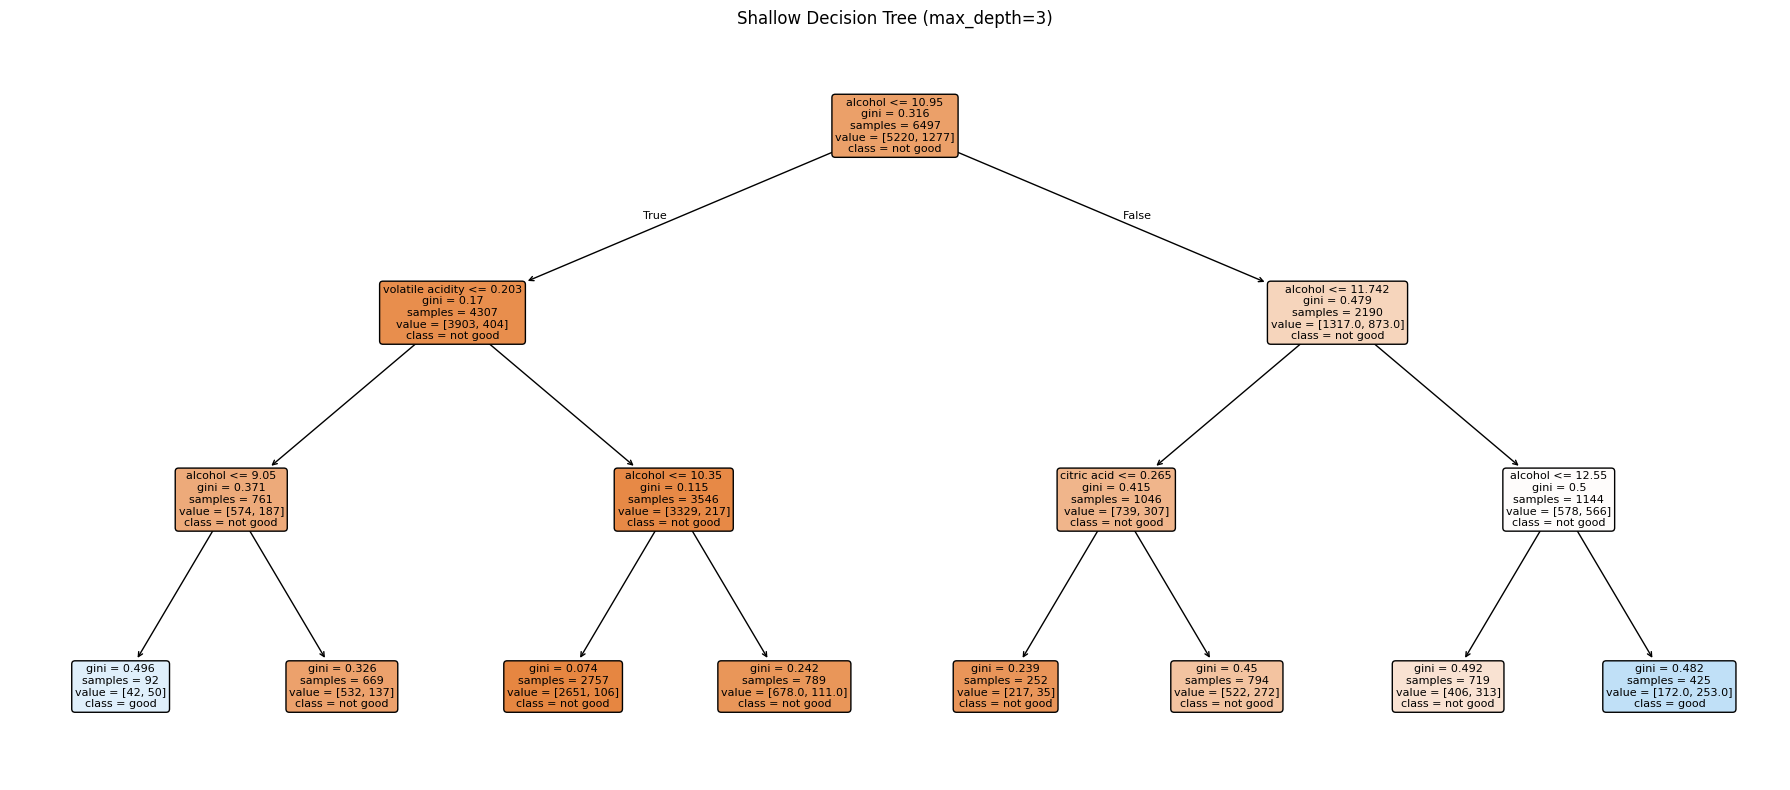

In [77]:
from sklearn.tree import DecisionTreeClassifier as SkDecisionTreeClassifier
from sklearn import tree

dt_shallow_sklearn = SkDecisionTreeClassifier(
    max_depth=3,
    random_state=42
)

dt_shallow_sklearn.fit(X, y)

plt.figure(figsize=(18, 8))
tree.plot_tree(
    dt_shallow_sklearn,
    feature_names=numeric_features_for_tree,
    class_names=["not good", "good"],
    filled=True,
    rounded=True,
    fontsize=8
)
plt.title("Shallow Decision Tree (max_depth=3)")
plt.tight_layout()
plt.show()


The shallow decision tree shows that alcohol is the absolute main factor for predicting wine quality. The root split is based on alcohol, and remarkably, the right branch continues to split purely on higher alcohol thresholds rather than other chemicals.
On the low-alcohol side (≤ 10.95), most wines are classified as "not good". Only a tiny region with very low volatile acidity (≤ 0.203) combined with very low alcohol (≤ 9.05) gets classified as "good", although the leaf is extremely mixed (50 good vs 42 not good).
On the high-alcohol side (> 10.95), the tree logic is simple: the more alcohol, the better. The primary "good wine" leaf is found only when alcohol is very high (> 12.55). Interestingly, wines with moderately high alcohol (between 11.74 and 12.55) are still classified as "not good".


"GOOD" LEAVES CONDITIONS:

leaf no.1 condition:
alcohol <= 10.95 -> volatile acidity <= 0.203 -> alcohol <= 9.05
leaf no.2 condition:
alcohol > 10.95 -> alcohol > 11.742 -> alcohol > 12.55

In [78]:
#18 deep learning model

from pyspark.ml.classification import MultilayerPerceptronClassifier


input_size = len(feature_cols_clf)
output_size = 2 

# 3 layer: input -> 16 -> 8 -> 2
layers = [input_size, 16, 8, output_size]

mlp_clf = MultilayerPerceptronClassifier(
    labelCol="label",
    featuresCol="features_clf",
    maxIter=100,
    layers=layers,
    blockSize=128,
    seed=42
)

pipeline_mlp = Pipeline(stages=[indexer_clf, assembler_clf, scaler_clf, mlp_clf])

mlp_model = pipeline_mlp.fit(train_clf)
pred_mlp = mlp_model.transform(test_clf)


acc_mlp = evaluator_acc.evaluate(pred_mlp)
f1_mlp  = evaluator_f1.evaluate(pred_mlp)

print("=== MultilayerPerceptronClassifier (deep learning) ===")
print(f"Accuracy: {acc_mlp:.3f}")
print(f"F1-score: {f1_mlp:.3f}")


=== MultilayerPerceptronClassifier (deep learning) ===
Accuracy: 0.810
F1-score: 0.785


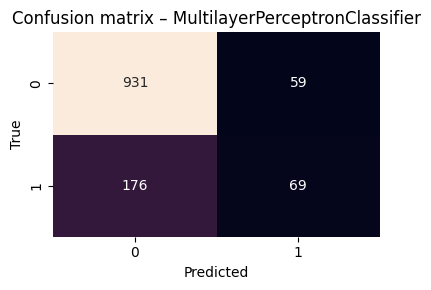

Confusion matrix (MLP):
[[931  59]
 [176  69]]


In [79]:
# 19 confusion matrix for the deep learning model 

from sklearn.metrics import confusion_matrix

y_true_dl = np.array(pred_mlp.select("label").toPandas()["label"])
y_pred_dl = np.array(pred_mlp.select("prediction").toPandas()["prediction"])

cm_dl = confusion_matrix(y_true_dl, y_pred_dl)

plt.figure(figsize=(4, 3))
sns.heatmap(cm_dl, annot=True, fmt="d", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion matrix – MultilayerPerceptronClassifier")
plt.tight_layout()
plt.show()

print("Confusion matrix (MLP):")
print(cm_dl)



MultilayerPerceptronClassifier (deep learning) is doing worser than RF according to Accuracy and F1